In [116]:
!pip install SpeechRecognition
!pip install matplotlib
!pip install librosa
!pip install pandas
!pip install tensorflow
!pip install transformers datasets evaluate seqeval
!pip install tf-keras
!pip install tensorflow[and-cuda]
!pip install ipywidgets --upgrade

In [117]:
import os
import librosa
import numpy as np
import json
import pandas as pd

In [118]:
# import speech_recognition as sr
# recognizer = sr.Recognizer()
# # input a file_path to a .wav file
# # returns the transcribed audio as a string
# # we can use BERT like in the homework to then tokenize/make into array and analyze it
# def getVectorOfWords(file_path):
#     with sr.AudioFile(file_path) as source:
#         audio = recognizer.record(source)
#     try:
#         # print("Transcription:", recognizer.recognize_google(audio))
#         return "" + recognizer.recognize_google(audio)
#     except sr.UnknownValueError:
#         return None

In [119]:
# removes all files from images folder so subsequent runs don't have weird overlaps
# def clearImagesFolder():
#     print("Deleting all data from images folder")
#     directory = os.getcwd() + "/images"
#     for root, dirs, files in os.walk(directory, topdown=False):  # topdown=False to delete files before dirs
#         for file_name in files:
#             file_path = os.path.join(root, file_name)
#             if os.path.isfile(file_path) and file_name.endswith('.png'):
#                 os.remove(file_path)
#                 # print("" + file_path + " has been removed successfully")
#     print("All images removed successfully!")

In [120]:
# import librosa.display
# import matplotlib.pyplot as plt
# # input a file_path to a .wav file
# # returns a png of the spectogram and a filepath to it
# def getSpectogram(file_path, emotion_label):
#     y, sr = librosa.load(file_path, sr=None) # load in the audio file and preserve its sample rate (replace with 16,000 if needed)
    
#     # Compute the spectrogram
#     D = librosa.stft(y)                        # Short-Time Fourier Transform
#     S_db = librosa.amplitude_to_db(abs(D), ref=np.max)  # Convert to decibel scale

#     # Plot and save the spectrogram
#     fig = plt.figure(figsize=(6, 6))                # Set the figure size -- > num pixels will be 100 times this
#     # can change the cmap to "viridis" or "plasma" for different color themes
#     librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="log", cmap="magma")  # Log frequency scale to mimic human audio perception

#     # TODO: at first try hiding as many extra features as possible and compare to when they're included
#     # plt.colorbar(format="%+2.0f dB")           # Add a colorbar
#     # plt.title("Spectrogram")
#     # plt.xlabel("Time (s)")
#     # plt.ylabel("Frequency (Hz)")
#     plt.tight_layout()
    
#     # Save the spectrogram as an image file
#     processed_path = (file_path.split("/")[-1]).split(".")[0]
#     output_image_path = f"./images/{emotion_label}/{processed_path}.png"  # TODO: figure out naming conventions for the file -- either use path or just have a counter that we pass in
#     plt.savefig(output_image_path, dpi=300)    # Save as PNG with high resolution
#     plt.close()                                # Close the figure to free memory
    
#     return output_image_path

In [121]:
# def getTargetEmotionFromCSV(audio_file_name):
#     # parse audio_file_name to get distinguishing file info for CSV lookup
#     dialogueID, utteranceID = (audio_file_name.split(".wav")[0]).split('_')
#     dialogueID, utteranceID = int(dialogueID[3:]), int(utteranceID[3:])
#     csv = pd.read_csv('./train_sent_emo.csv')
#     # Filter the row(s) that satisfy both conditions
#     condition1 = (csv['Dialogue_ID'] == dialogueID)  # First column matches 'dialogueID'
#     condition2 = (csv['Utterance_ID'] == utteranceID)  # Second column matches 'utteranceID'
#     filtered_rows = csv[condition1 & condition2]
#     return filtered_rows['Emotion'].iloc[0]

In [122]:
# def traverse_audio_files(directory="./train_splits_wav"):
#     # clearImagesFolder() # deletes everything from the image folder
#     data = []
    
#     # Traverse and process .wav files
#     print("Starting audio file traversal")
#     iterCount = 0
#     for file_name in os.listdir(directory):
#         # limit the number of loops so this doesn't take THAT long
#         if iterCount >= 3000:
#             break
#         file_path = os.path.join(directory, file_name)
        
#         if os.path.isfile(file_path) and file_name.endswith('.wav'):
#             transcription = getVectorOfWords(file_path)
#             # filter out the audio files that can't get a clear transcription
#             if not transcription:
#                 continue
#             emotion = getTargetEmotionFromCSV(file_name)
#             image_path = getSpectogram(file_path, emotion)
#             data.append({"Transcription": transcription, "Spectogram": image_path, "Emotion": emotion})
#         iterCount += 1
#     df = pd.DataFrame(data)
#     print("Finished creating dataframe and traversing audio files")
#     return df

In [123]:
# df = traverse_audio_files()
# df.to_csv('data3000.csv', index=False)
# print(df)

In [124]:
df = pd.read_csv('data9000.csv')
emotion_labels = df['Emotion'].unique()
print(emotion_labels)
print(df)

# df = pd.read_csv('data_all_given_transcript.csv')
# emotion_labels = df['Emotion'].unique()
# print(emotion_labels)
# print(df)

['neutral' 'joy' 'fear' 'surprise' 'sadness' 'disgust' 'anger']
                                          Transcription  \
0                                                 Mrs M   
1                                     why did you write   
2                                 I heard what you said   
3                                            for a walk   
4     when did they made me head of purchasing thank...   
...                                                 ...   
3826  play Joey's lovable 2 but the thing about Joey...   
3827                                  what do you think   
3828                                         I guess so   
3829  so I'm just going to go back to talking to my ...   
3830                                               Ross   

                                 Spectogram   Emotion  
0      ./images9000/neutral/dia575_utt1.png   neutral  
1     ./images9000/neutral/dia689_utt12.png   neutral  
2      ./images9000/neutral/dia845_utt8.png   neutral  
3  

In [144]:
##### prepreocessing
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import keras.callbacks
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from transformers import DistilBertTokenizer
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


### balance dataset
balance = True
if balance:
    neutral_class = 0  # Replace this with the actual index for "neutral" in factorized labels
    neutral_data = df[df['Emotion'] == "neutral"]
    non_neutral_data = df[df['Emotion'] != "neutral"]
    # Undersample the "neutral" class
    neutral_downsampled = resample(
        neutral_data,
        replace=False,  # Don't sample with replacement
        n_samples= int(df['Emotion'].value_counts().mean()),  # scale dwon the size
        random_state=42
    )
    
    # Combine undersampled "neutral" with other classes
    balanced_df = pd.concat([neutral_downsampled, non_neutral_data])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the dataset for training

    texts = list(balanced_df['Transcription'])
    input_ids = tokens['input_ids'].numpy()
    attention_masks = tokens['attention_mask'].numpy()
    image_paths = list(balanced_df['Spectogram'])
    labels = pd.factorize(balanced_df['Emotion'])[0] # Re-factorize the labels after balancing
else:
    df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the dataset for training
    texts = list(df['Transcription'])
    input_ids = tokens['input_ids'].numpy()  # Convert to NumPy array
    attention_masks = tokens['attention_mask'].numpy()
    image_paths = list(df['Spectogram'])
    labels = pd.factorize(df['Emotion'])[0]  # Convert categorical to integers
### prep for BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors="pt") # Tokenize transcriptions

### prep for CNN
images = []

for path in image_paths:
    # Load image
    img = load_img(path, target_size=(128, 128))  # Resize to (128, 128)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    images.append(img_array)

images = np.array(images)  # Shape: (batch_size, 128, 128, 3)
### split the data
# Step 1: Split data into training + validation and test sets
x_images_trainval, x_images_test, x_text_trainval, x_text_test, x_attention_trainval, x_attention_test, y_trainval, y_test = train_test_split(
    images, input_ids, attention_masks, labels, test_size=0.15, random_state=42, stratify=labels
)
# Step 2: Further split training + validation into training and validation sets
x_images_train, x_images_val, x_text_train, x_text_val, x_attention_train, x_attention_val, y_train, y_val = train_test_split(
    x_images_trainval, x_text_trainval, x_attention_trainval, y_trainval, test_size=0.15, random_state=42, stratify=y_trainval
)

In [146]:
if balance:
    print("balanced\n", balanced_df['Emotion'].value_counts()) # balanced distribution
    print()
print("original\n", df['Emotion'].value_counts())  # Original distribution

balanced
 Emotion
joy         610
neutral     547
anger       418
surprise    406
sadness     324
fear         98
disgust      94
Name: count, dtype: int64
original
 Emotion
neutral     1881
joy          610
anger        418
surprise     406
sadness      324
fear          98
disgust       94
Name: count, dtype: int64


In [147]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from transformers import TFDistilBertModel

# BERT Model Wrapper
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
    
    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, training=training)
        return outputs.last_hidden_state[:, 0, :]  # CLS token embedding

# BERT Branch
text_input = layers.Input(shape=(46,), dtype='int32', name='text_input')  # Adjust shape accordingly
attention_input = layers.Input(shape=(46,), dtype='int32', name='attention_input')
bert_output = BertLayer()([text_input, attention_input])
bert_dense = layers.Dense(128, activation='relu')(bert_output)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [148]:
# make array for cnn_models
cnn_models = []

In [149]:
# CNN Branch -- model 8
image_input = layers.Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
cnn_dense = layers.Dense(128, activation='relu')(x)

# Combine BERT and CNN Outputs
combined = layers.Concatenate()([bert_dense, cnn_dense])
combined_dense = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(10, activation='softmax')(combined_dense)  # Replace `10` with `num_classes`

# Define and Compile Model
model8 = Model(inputs=[text_input, attention_input, image_input], outputs=output)
model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model8.summary())

cnn_models.append(("model8", model8))

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_212 (Conv2D) │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_204   │ (None, 63, 63,    │          0 │ conv2d_212[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_213 (Conv2D) │ (None, 61, 61,    │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_205   │ (None, 30, 30,    │          0 │ conv2d_213[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_input     │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_38          │ (None, 57600)     │          0 │ max_pooling2d_20… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_6        │ (None, 768)       │          0 │ text_input[0][0], │
│ (BertLayer)         │                   │            │ attention_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 57600)     │          0 │ flatten_38[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 128)       │     98,432 │ bert_layer_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_136 (Dense)   │ (None, 128)       │  7,372,928 │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_38      │ (None, 256)       │          0 │ dense_135[0][0],  │
│ (Concatenate)       │                   │            │ dense_136[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_137 (Dense)   │ (None, 64)        │     16,448 │ concatenate_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_138 (Dense)   │ (None, 10)        │        650 │ dense_137[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,507,850 (28.64 MB)

 Trainable params: 7,507,850 (28.64 MB)

 Non-trainable params: 0 (0.00 B)

None


In [150]:
# CNN Branch -- model 10
image_input = layers.Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
cnn_dense = layers.Dense(128, activation='relu')(x)

# Combine BERT and CNN Outputs
combined = layers.Concatenate()([bert_dense, cnn_dense])
combined_dense = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(10, activation='softmax')(combined_dense)  # Replace `10` with `num_classes`

# Define and Compile Model
model10 = Model(inputs=[text_input, attention_input, image_input], outputs=output)
model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model10.summary())

cnn_models.append(("model10", model10))

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_214 (Conv2D) │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_206   │ (None, 63, 63,    │          0 │ conv2d_214[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_215 (Conv2D) │ (None, 61, 61,    │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_207   │ (None, 30, 30,    │          0 │ conv2d_215[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_216 (Conv2D) │ (None, 28, 28,    │     36,928 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_208   │ (None, 14, 14,    │          0 │ conv2d_216[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_input     │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_39          │ (None, 12544)     │          0 │ max_pooling2d_20… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_6        │ (None, 768)       │          0 │ text_input[0][0], │
│ (BertLayer)         │                   │            │ attention_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 12544)     │          0 │ flatten_39[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 128)       │     98,432 │ bert_layer_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_139 (Dense)   │ (None, 128)       │  1,605,760 │ dropout_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_39      │ (None, 256)       │          0 │ dense_135[0][0],  │
│ (Concatenate)       │                   │            │ dense_139[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_140 (Dense)   │ (None, 64)        │     16,448 │ concatenate_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_141 (Dense)   │ (None, 10)        │        650 │ dense_140[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,777,610 (6.78 MB)

 Trainable params: 1,777,610 (6.78 MB)

 Non-trainable params: 0 (0.00 B)

None


In [151]:
# CNN Branch -- model 12
image_input = layers.Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
cnn_dense = layers.Dense(128, activation='relu')(x)

# Combine BERT and CNN Outputs
combined = layers.Concatenate()([bert_dense, cnn_dense])
combined_dense = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(10, activation='softmax')(combined_dense)  # Replace `10` with `num_classes`

# Define and Compile Model
model12 = Model(inputs=[text_input, attention_input, image_input], outputs=output)
model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model12.summary())

cnn_models.append(("model12", model12))

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_217 (Conv2D) │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_209   │ (None, 63, 63,    │          0 │ conv2d_217[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_218 (Conv2D) │ (None, 61, 61,    │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_210   │ (None, 30, 30,    │          0 │ conv2d_218[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_219 (Conv2D) │ (None, 28, 28,    │     36,928 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_211   │ (None, 14, 14,    │          0 │ conv2d_219[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_220 (Conv2D) │ (None, 12, 12,    │     36,928 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_212   │ (None, 6, 6, 64)  │          0 │ conv2d_220[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_input     │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_40          │ (None, 2304)      │          0 │ max_pooling2d_21… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_6        │ (None, 768)       │          0 │ text_input[0][0], │
│ (BertLayer)         │                   │            │ attention_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 2304)      │          0 │ flatten_40[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 128)       │     98,432 │ bert_layer_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_142 (Dense)   │ (None, 128)       │    295,040 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_40      │ (None, 256)       │          0 │ dense_135[0][0],  │
│ (Concatenate)       │                   │            │ dense_142[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 503,818 (1.92 MB)

 Trainable params: 503,818 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

None


In [152]:
# CNN Branch -- model 13
image_input = layers.Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
cnn_dense = layers.Dense(128, activation='relu')(x)

# Combine BERT and CNN Outputs
combined = layers.Concatenate()([bert_dense, cnn_dense])
combined_dense = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(10, activation='softmax')(combined_dense)  # Replace `10` with `num_classes`

# Define and Compile Model
model13 = Model(inputs=[text_input, attention_input, image_input], outputs=output)
model13.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model13.summary())

cnn_models.append(("model13", model13))

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_221 (Conv2D) │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_213   │ (None, 63, 63,    │          0 │ conv2d_221[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_222 (Conv2D) │ (None, 61, 61,    │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_214   │ (None, 30, 30,    │          0 │ conv2d_222[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 30, 30,    │          0 │ max_pooling2d_21… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_223 (Conv2D) │ (None, 28, 28,    │     36,928 │ dropout_48[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_215   │ (None, 14, 14,    │          0 │ conv2d_223[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_224 (Conv2D) │ (None, 12, 12,    │     36,928 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_216   │ (None, 6, 6, 64)  │          0 │ conv2d_224[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_input     │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_41          │ (None, 2304)      │          0 │ max_pooling2d_21… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_6        │ (None, 768)       │          0 │ text_input[0][0], │
│ (BertLayer)         │                   │            │ attention_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 2304)      │          0 │ flatten_41[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_135 (Dense)   │ (None, 128)       │     98,432 │ bert_layer_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_145 (Dense)   │ (None, 128)       │    295,040 │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 503,818 (1.92 MB)

 Trainable params: 503,818 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

None


In [153]:
# CNN Branch -- model 15
image_input = layers.Input(shape=(128, 128, 3), name='image_input')
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
cnn_dense = layers.Dense(128, activation='relu')(x)

# Combine BERT and CNN Outputs
combined = layers.Concatenate()([bert_dense, cnn_dense])
combined_dense = layers.Dense(64, activation='relu')(combined)
output = layers.Dense(10, activation='softmax')(combined_dense)  # Replace `10` with `num_classes`

# Define and Compile Model
model15 = Model(inputs=[text_input, attention_input, image_input], outputs=output)
model15.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model15.summary())

cnn_models.append(("model15", model15))

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_225 (Conv2D) │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_217   │ (None, 63, 63,    │          0 │ conv2d_225[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_226 (Conv2D) │ (None, 61, 61,    │     18,496 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_218   │ (None, 30, 30,    │          0 │ conv2d_226[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_227 (Conv2D) │ (None, 28, 28,    │     36,928 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_219   │ (None, 14, 14,    │          0 │ conv2d_227[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_228 (Conv2D) │ (None, 12, 12,    │     36,928 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_220   │ (None, 6, 6, 64)  │          0 │ conv2d_228[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_148 (Dense)   │ (None, 6, 6, 128) │      8,320 │ max_pooling2d_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_229 (Conv2D) │ (None, 4, 4, 64)  │     73,792 │ dense_148[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_221   │ (None, 2, 2, 64)  │          0 │ conv2d_229[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_input     │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_42          │ (None, 256)       │          0 │ max_pooling2d_22… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_6        │ (None, 768)       │          0 │ text_input[0][0], │
│ (BertLayer)         │                   │            │ attention_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 256)       │          0 │ flatten_42[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 323,786 (1.24 MB)

 Trainable params: 323,786 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

None


In [173]:
##### train the model
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Metric to monitor (e.g., validation loss)
    patience=5,            # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restore the best weights once training stops
)

histories = []
valid_maxes = []
for label, model in cnn_models:
    print(label)
    # Train the model
    history = model.fit(
        x={'text_input': x_text_train, 'attention_input': x_attention_train, 'image_input': x_images_train},
        y=y_train,
        batch_size=32,
        epochs=50,
        validation_data=(
            {'text_input': x_text_val, 'attention_input': x_attention_val, 'image_input': x_images_val},
            y_val
        ),
        callbacks=[early_stopping]
    )
    histories.append((label, history))
    num_layers = int(label.split("l")[1])
    valid_maxes.append((num_layers, max(history.history['val_accuracy']) * 100))
    print("Best validation accuracy percentage:", max(history.history['val_accuracy']) * 100, "%\n")

model8
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7747 - loss: 0.6700 - val_accuracy: 0.3323 - val_loss: 2.0706
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8172 - loss: 0.5508 - val_accuracy: 0.3135 - val_loss: 2.1247
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8632 - loss: 0.4276 - val_accuracy: 0.3448 - val_loss: 2.2588
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8925 - loss: 0.3388 - val_accuracy: 0.3511 - val_loss: 2.3616
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9369 - loss: 0.2461 - val_accuracy: 0.3197 - val_loss: 2.6285
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9266 - loss: 0.2514 - val_accuracy: 0.3197 - val_loss: 2.6250
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9445 - loss: 0.2123 - val_accuracy: 0.3511 - val_loss: 2.6587
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9715 - loss: 0.1203 - val_accuracy: 0.3

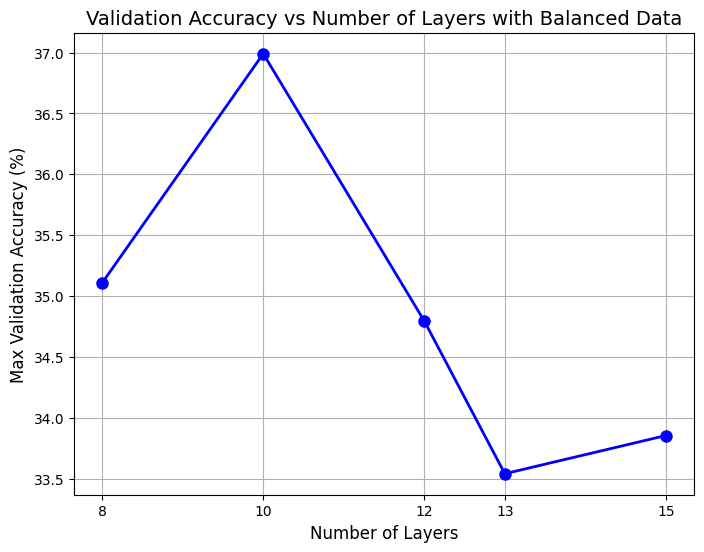

In [174]:
### graph models and their max validation accuracies
# Extract the number of layers and corresponding validation accuracies
num_layers = [x[0] for x in valid_maxes]
val_accuracies = [x[1] for x in valid_maxes]

# Plotting the trend
plt.figure(figsize=(8, 6))
plt.plot(num_layers, val_accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Add titles and labels
plt.xlabel('Number of Layers', fontsize=12)
plt.ylabel('Max Validation Accuracy (%)', fontsize=12)

# Show grid and plot
plt.grid(True)
plt.xticks(num_layers)  # To ensure each x-tick is labeled
if balance:
    plt.title('Validation Accuracy vs Number of Layers with Balanced Data', fontsize=14)
    plt.savefig('./plots/numlayers_vs_val_acc_balanced', dpi=300)
else:
    plt.title('Validation Accuracy vs Number of Layers with Unbalanced Data', fontsize=14)
    plt.savefig('./plots/numlayers_vs_val_acc_unbalanced', dpi=300)
plt.show()

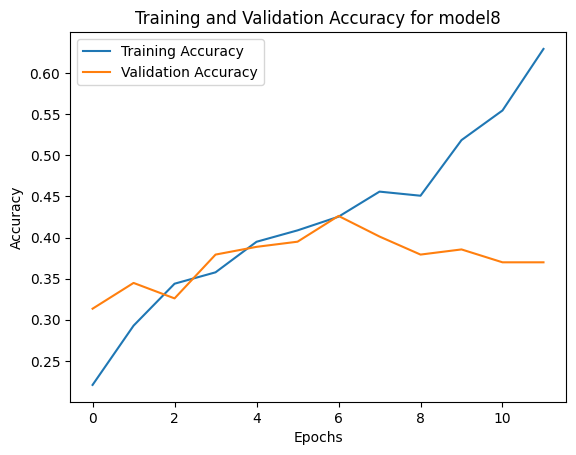

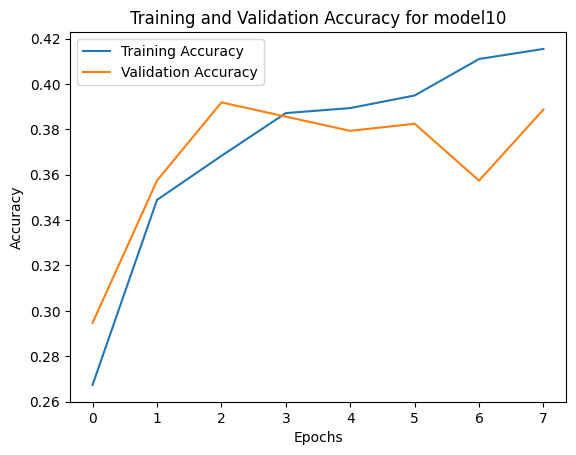

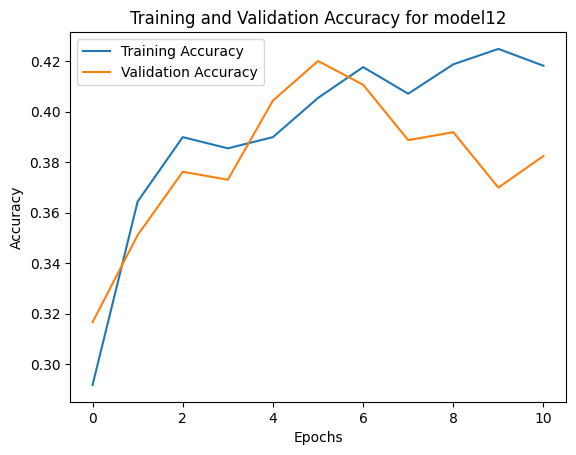

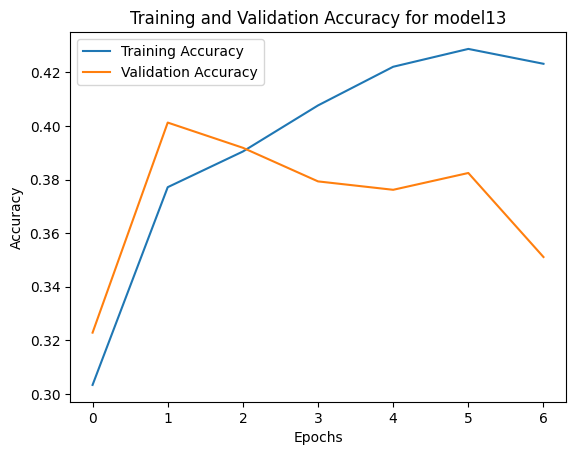

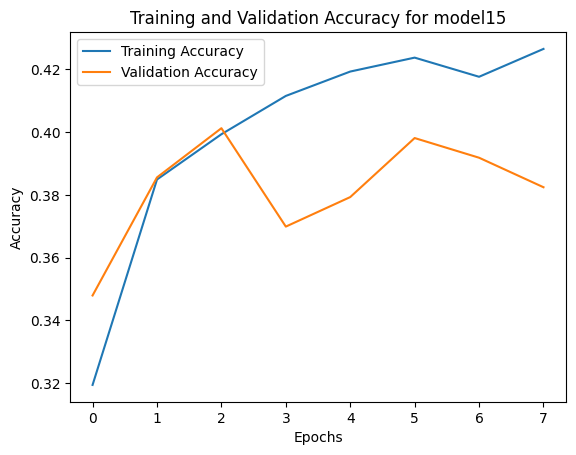

In [158]:
### graphs
import matplotlib.pyplot as plt
# Plot training vs. validation accuracy
for name, history in histories:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./plots/train_vs_val_acc', dpi=300)
    plt.show()

In [175]:
from sklearn.metrics import accuracy_score, f1_score

predictions = []
# Predict on the test data
for name, model in cnn_models:
    print(name)
    y_pred = model.predict({'text_input': x_text_test, 'attention_input': x_attention_test, 'image_input': x_images_test})
    y_pred_classes = y_pred.argmax(axis=1)  # Convert softmax outputs to class predictions
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")
    
    f1 = f1_score(y_test, y_pred_classes, average='weighted')  # Use 'weighted' to account for class imbalance
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    f1_per_class = f1_score(y_test, y_pred_classes, average=None)
    for idx, label in enumerate(emotion_labels):
        print(f"F1 Score for {label}: {f1_per_class[idx]:.4f}")
    predictions.append((name, y_pred_classes))

model8
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.3093
F1 Score (Weighted): 0.2975
F1 Score for neutral: 0.3750
F1 Score for joy: 0.2400
F1 Score for fear: 0.2941
F1 Score for surprise: 0.2991
F1 Score for sadness: 0.3333
F1 Score for disgust: 0.1053
F1 Score for anger: 0.0000
model10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.3680
F1 Score (Weighted): 0.3616
F1 Score for neutral: 0.4372
F1 Score for joy: 0.3619
F1 Score for fear: 0.2667
F1 Score for surprise: 0.4553
F1 Score for sadness: 0.3815
F1 Score for disgust: 0.1481
F1 Score for anger: 0.0000
model12
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.3467
F1 Score (Weighted): 0.3477
F1 Score for neutral: 0.4417
F1 Score for joy: 0.3838
F1 Score for fear: 0.3117
F1 Score for surprise: 0.3934
F1 Score for sadness: 0.2981
F1 Score for disgust: 0.0870
F1 Score for anger: 0.1429
model13
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy: 0.3387
F1 Score (Weighted): 0.3354
F1 Score for neutral: 0.4432
F1 Score for jo

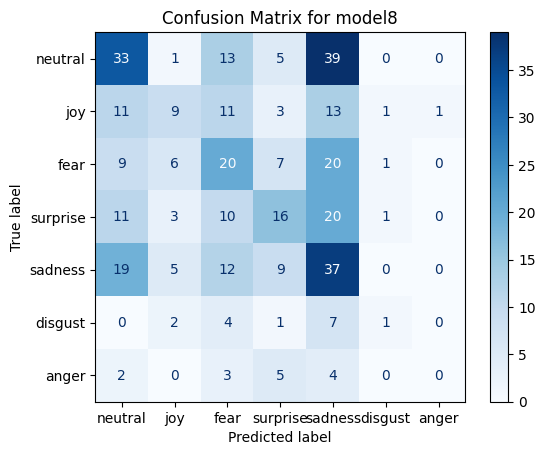

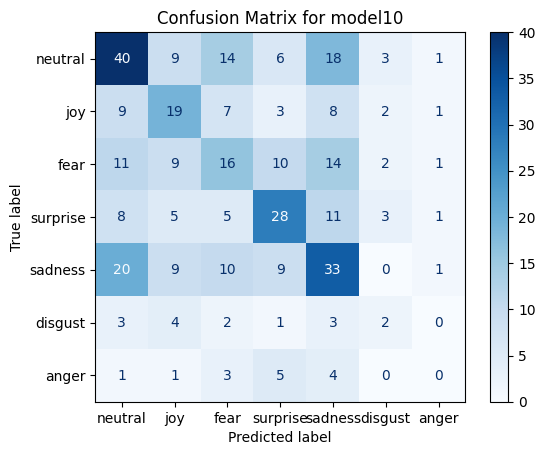

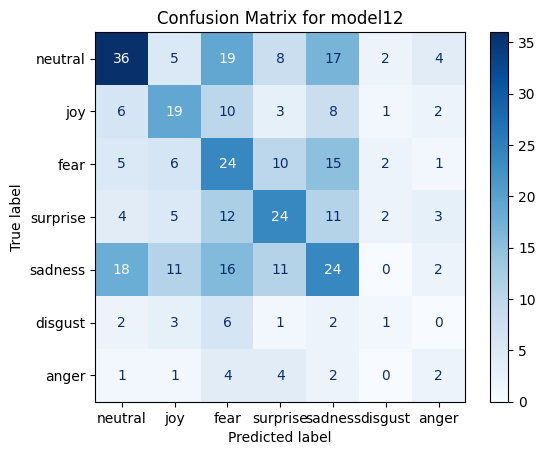

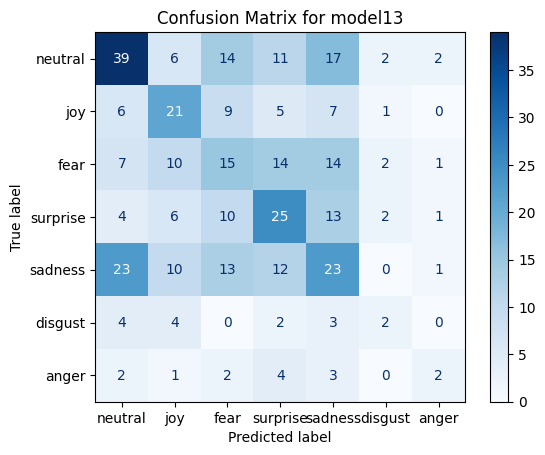

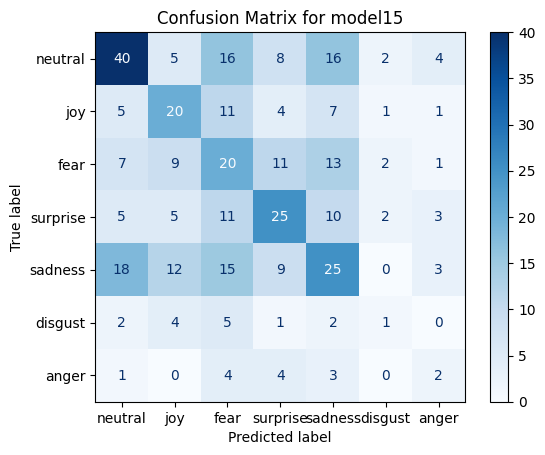

In [176]:
## could either move this into the for loop above or save the y_pred_classes in an array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for name, pred_classes in predictions:
    # Compute confusion matrix
    cm = confusion_matrix(y_test, pred_classes)
    
    # Plot confusion matrix as a heatmap
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name}')
    # plt.savefig('./plots/confusion_matrix', dpi=300)
    plt.show()


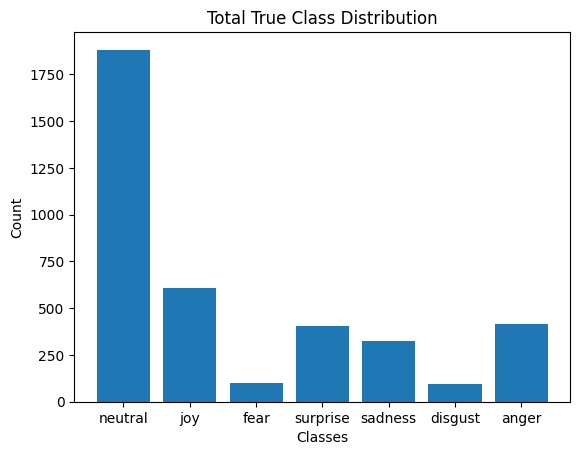

In [137]:
# Combine the true labels from the training, validation, and test sets
y_all_classes = np.concatenate([y_train, y_val, y_test])

# Plot class distribution of all labels
unique, counts = np.unique(y_all_classes, return_counts=True)
plt.bar(unique, counts, tick_label=emotion_labels)  # Use emotion_labels to label your classes
plt.title('Total True Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.savefig('./plots/total_true_class_distribution', dpi=300)
plt.show()


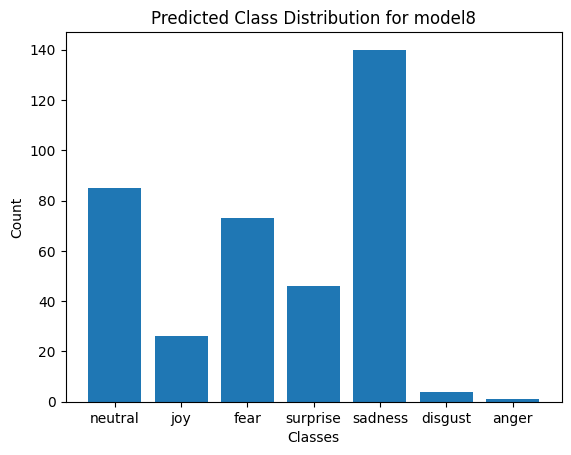

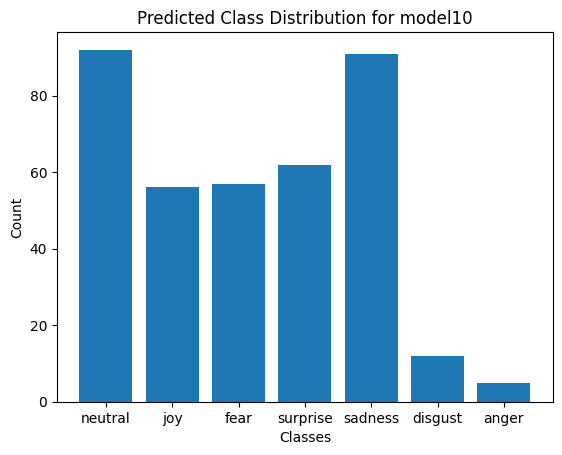

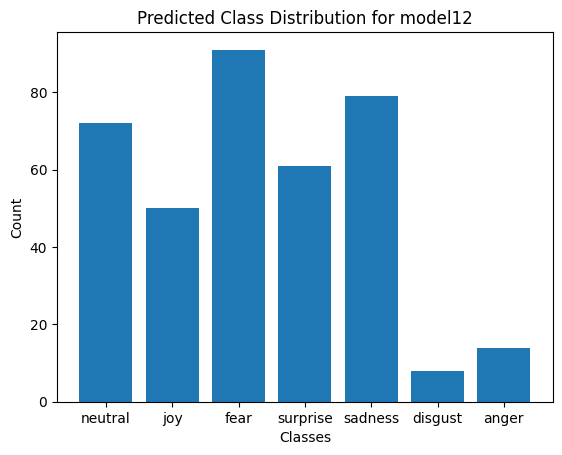

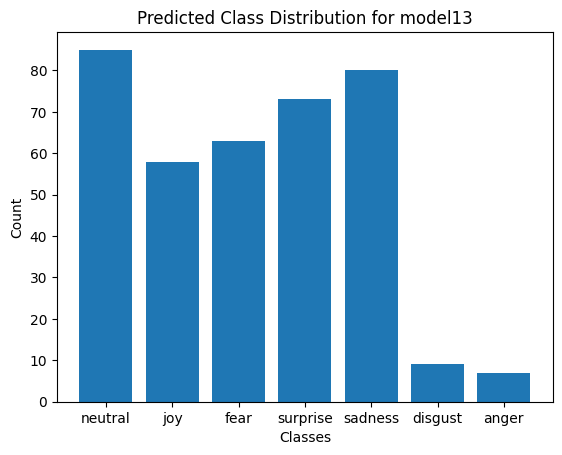

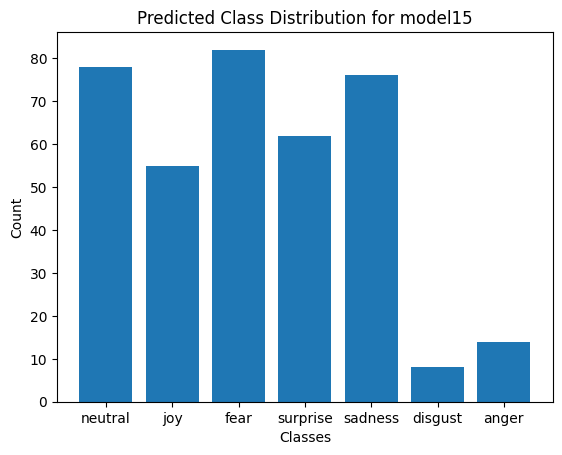

In [177]:
## could either move this into the for loop above or save the y_pred_classes in an array or something
for name, pred_classes in predictions:
    # Plot class distribution
    unique, counts = np.unique(pred_classes, return_counts=True)
    plt.bar(unique, counts, tick_label=emotion_labels)
    plt.title(f'Predicted Class Distribution for {name}')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    # plt.savefig('./plots/pred_class_distribution', dpi=300)
    plt.show()
